# Complicate the UNET model from the seminar, train it on the OXFORD-PETS dataset, and achieve 88% pixel-level accuracy. 

To do this, you will need to add more downblocks and upblocks to it, and possibly increase the base_channels.

Use the following transform for images:
```python
transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.ToTensor(),
    ])
```



Submit your predictions for the test sample of this dataset (split=‘test’). Make predictions for the following objects:
```python
np.random.seed(100)
idx = np.random.randint(len(valid_dataset), size=200)
```

Upload your predictions to the checker using the torch.save functions. Your prediction tensor should have the size [200, 1, 256, 256].

In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet, CIFAR10
import kagglehub

#the_oxfordiiit_pet_dataset_path = kagglehub.dataset_download('devdgohil/the-oxfordiiit-pet-dataset')

#dataset_train = CIFAR10('/kaggle/input/cifar10', train=True, transform=T.ToTensor())
dataset = OxfordIIITPet(
    root='./kaggle/input/the-oxfordiiit-pet-dataset',
    split='trainval',
    download=True,
    target_types='segmentation',
)

transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.ToTensor(),
    ]
)

target_transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.PILToTensor(),
        T.Lambda(lambda x: (x - 1).long())
    ]
)

train_dataset = OxfordIIITPet('./kaggle/input/the-oxfordiiit-pet-dataset', transform=transform, target_transform=target_transform, target_types='segmentation')
valid_dataset = OxfordIIITPet('./kaggle/input/the-oxfordiiit-pet-dataset', transform=transform, split='test', target_transform=target_transform, target_types='segmentation')

100%|██████████| 791918971/791918971 [00:28<00:00, 27355826.46it/s]


Extracting kaggle/input/the-oxfordiiit-pet-dataset/oxford-iiit-pet/images.tar.gz to kaggle/input/the-oxfordiiit-pet-dataset/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 8953085.78it/s] 


Extracting kaggle/input/the-oxfordiiit-pet-dataset/oxford-iiit-pet/annotations.tar.gz to kaggle/input/the-oxfordiiit-pet-dataset/oxford-iiit-pet


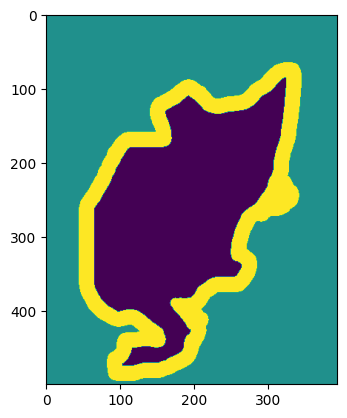

In [2]:
plt.imshow(dataset[0][1])


In [3]:
#!g1.1
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

In [4]:
from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy


@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy


from IPython.display import clear_output


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()


import numpy as np
from PIL import Image


@torch.inference_mode()
def visualize(model, batch):
    model.eval()

    xs, ys = batch
    
    to_pil = T.ToPILImage()

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = model(x.unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1]

        fig, ax = plt.subplots(1, 3, figsize=(24, 8), facecolor='white')

        ax[0].imshow(to_pil(x))
        ax[1].imshow(to_pil(y.to(torch.uint8)))
        ax[2].imshow(to_pil(prediction.to(torch.uint8)))

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

        ax[0].set_title('Original image')
        ax[1].set_title('Segmentation mask')
        ax[2].set_title('Prediction')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break


def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        visualize(model, next(iter(valid_loader)))

In [5]:
import torch.nn as nn


def conv_plus_conv(in_channels: int, out_channels: int):
    """
    Makes UNet block
    :param in_channels: input channels
    :param out_channels: output channels
    :return: UNet block
    """
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )


class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 32

        self.down1 = conv_plus_conv(3, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)
        self.down3 = conv_plus_conv(base_channels * 2, base_channels * 4)
        self.down4 = conv_plus_conv(base_channels * 4, base_channels * 8)
        self.down5 = conv_plus_conv(base_channels * 8, base_channels * 16)

        self.up1 = conv_plus_conv(base_channels * 2, base_channels)
        self.up2 = conv_plus_conv(base_channels * 3, base_channels)
        self.up3 = conv_plus_conv(base_channels * 5, base_channels)
        self.up4 = conv_plus_conv(base_channels * 9, base_channels)
        self.up5 = conv_plus_conv(base_channels * 32, base_channels)
        
        self.bottleneck = conv_plus_conv(base_channels * 16, base_channels * 16)

        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # x.shape = (N, N, 3)

        residual1 = self.down1(x)  # x.shape: (N, N, 3) -> (N, N, base_channels)
        x = self.downsample(residual1)  # x.shape: (N, N, base_channels) -> (N // 2, N // 2, base_channels)

        residual2 = self.down2(x)  # x.shape: (N // 2, N // 2, base_channels) -> (N // 2, N // 2, base_channels * 2)
        x = self.downsample(residual2)  # x.shape: (N // 2, N // 2, base_channels * 2) -> (N // 4, N // 4, base_channels * 2)

        residual3 = self.down3(x)  # x.shape: (N // 4, N // 4, base_channels*2) -> (N // 4, N // 4, base_channels * 4)
        x = self.downsample(residual3)  # x.shape: (N // 4, N // 4, base_channels * 4) -> (N // 8, N // 8, base_channels * 4)

        residual4 = self.down4(x)  # x.shape: (N // 8, N // 8, base_channels * 4) -> (N // 8, N // 8, base_channels * 8)
        x = self.downsample(residual4)  # x.shape: (N // 8, N // 8, base_channels * 8) -> (N // 16, N // 16, base_channels * 8)

        residual5 = self.down5(x)  # x.shape: (N // 16, N // 16, base_channels * 8) -> (N // 16, N // 16, base_channels * 16)
        x = self.downsample(residual5)  # x.shape: (N // 16, N // 16, base_channels * 16) -> (N // 32, N // 32, base_channels * 16)

        
        # LATENT SPACE DIMENSION DIM = N // 16
        # SOME MANIPULATION MAYBE
        x = self.bottleneck(x)  # x.shape: (N // 32, N // 32, base_channels * 16) -> (N // 32, N // 32, base_channels * 16)
        # SOME MANIPULATION MAYBE
        # LATENT SPACE DIMENSION DIM = N // 4
        
        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 32, N // 32, base_channels * 16) -> (N // 16, N // 16, base_channels * 16)
        x = torch.cat((x, residual5), dim=1)  # x.shape: (N // 16, N // 16, base_channels * 16) -> (N // 16, N // 16, base_channels * 32)
        x = self.up5(x)  # x.shape: (N // 16, N // 16, base_channels * 32) -> (N // 16, N // 16, base_channels)
        
        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 16, N // 16, base_channels) -> (N // 8, N // 8, base_channels)
        x = torch.cat((x, residual4), dim=1)  # x.shape: (N // 8, N // 8, base_channels ) -> (N // 8, N // 8, base_channels * 9)
        x = self.up4(x)  # x.shape: (N // 8, N // 8, base_channels * 9) -> (N // 8, N // 8, base_channels)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 8, N // 8, base_channels) -> (N // 4, N // 4, base_channels)
        x = torch.cat((x, residual3), dim=1)  # x.shape: (N // 4, N // 4, base_channels) -> (N // 4, N // 4, base_channels * 5)
        x = self.up3(x)  # x.shape: (N // 4, N // 4, base_channels * 5) -> (N // 4, N // 4, base_channels)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 4, N // 4, base_channels) -> (N // 2, N // 2, base_channels)
        x = torch.cat((x, residual2), dim=1)  # x.shape: (N // 2, N // 2, base_channels) -> (N // 2, N // 2, base_channels * 3)
        x = self.up2(x)  # x.shape: (N // 2, N // 2, base_channels * 3) -> (N // 2, N // 2, base_channels)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 2, N // 2, base_channels) -> (N, N, base_channels)
        x = torch.cat((x, residual1), dim=1)  # x.shape: (N, N, base_channels) -> (N, N, base_channels * 2)
        x = self.up1(x)  # x.shape: (N, N, base_channels * 2) -> (N, N, base_channels)

        x = self.out(x)  # x.shape: (N, N, base_channels) -> (N, N, 3)

        return x

In [6]:
from torch.optim import Adam

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.CrossEntropyLoss()


model = UNET().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

cuda:0
Tesla T4


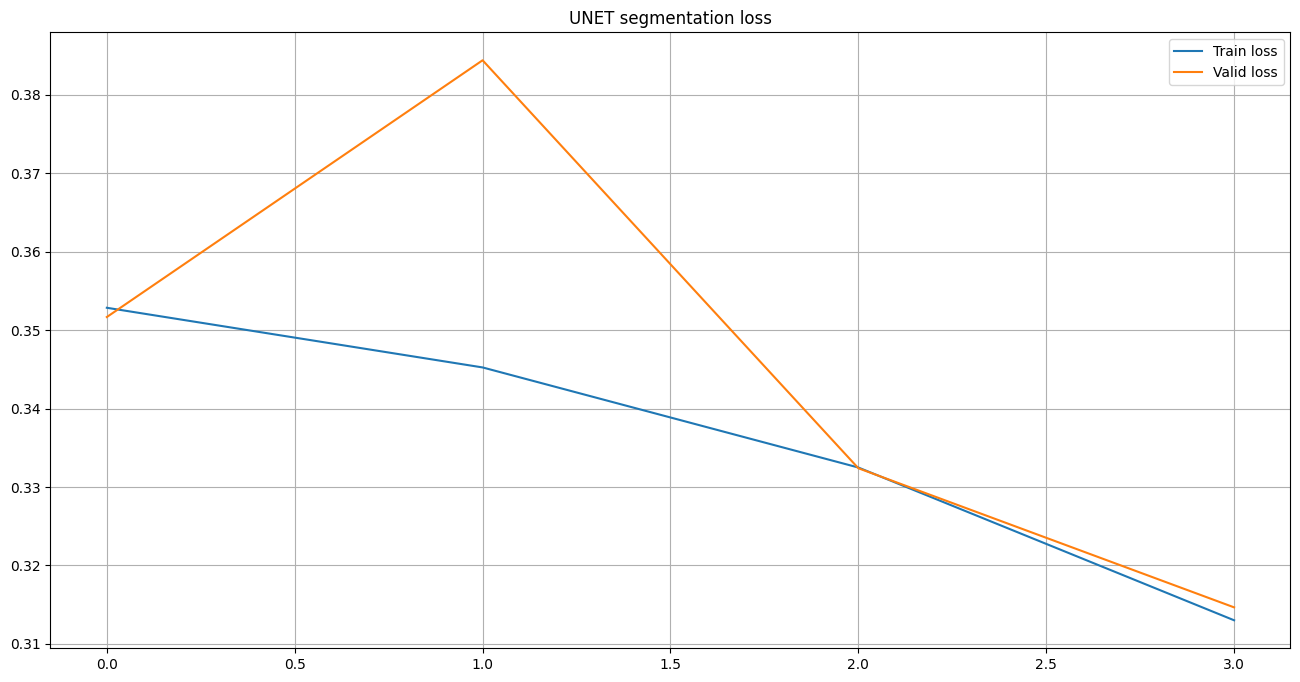

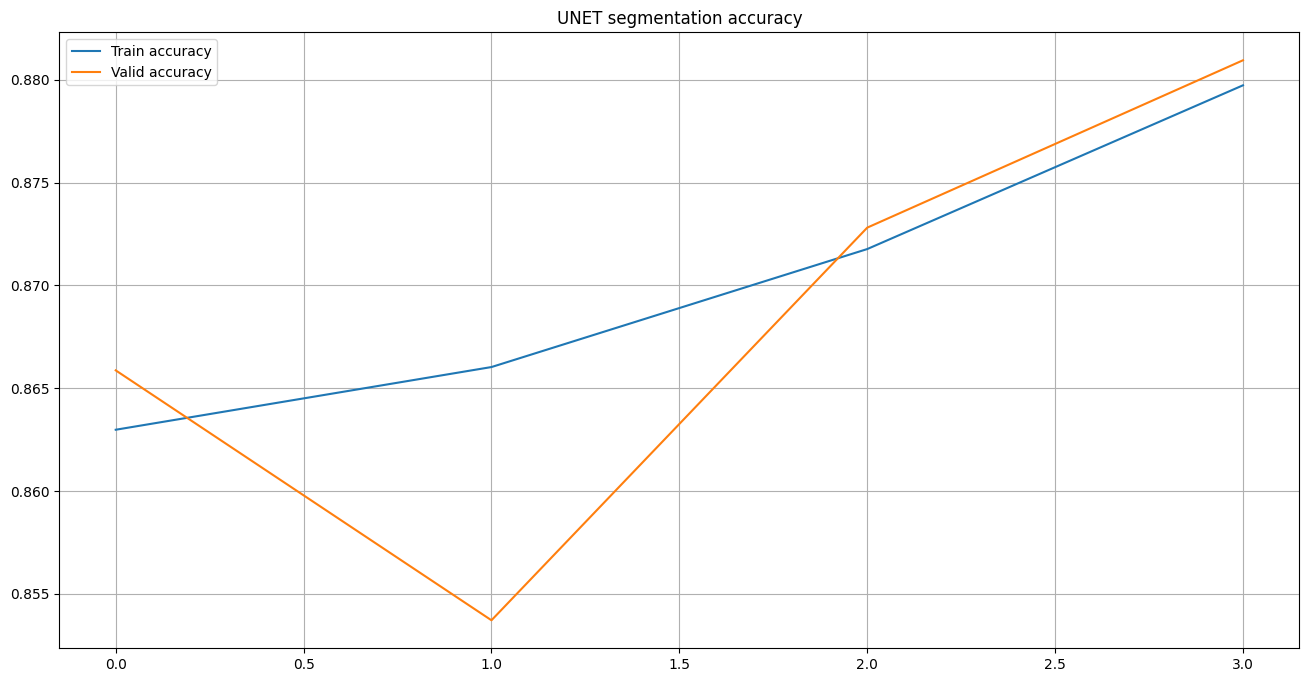

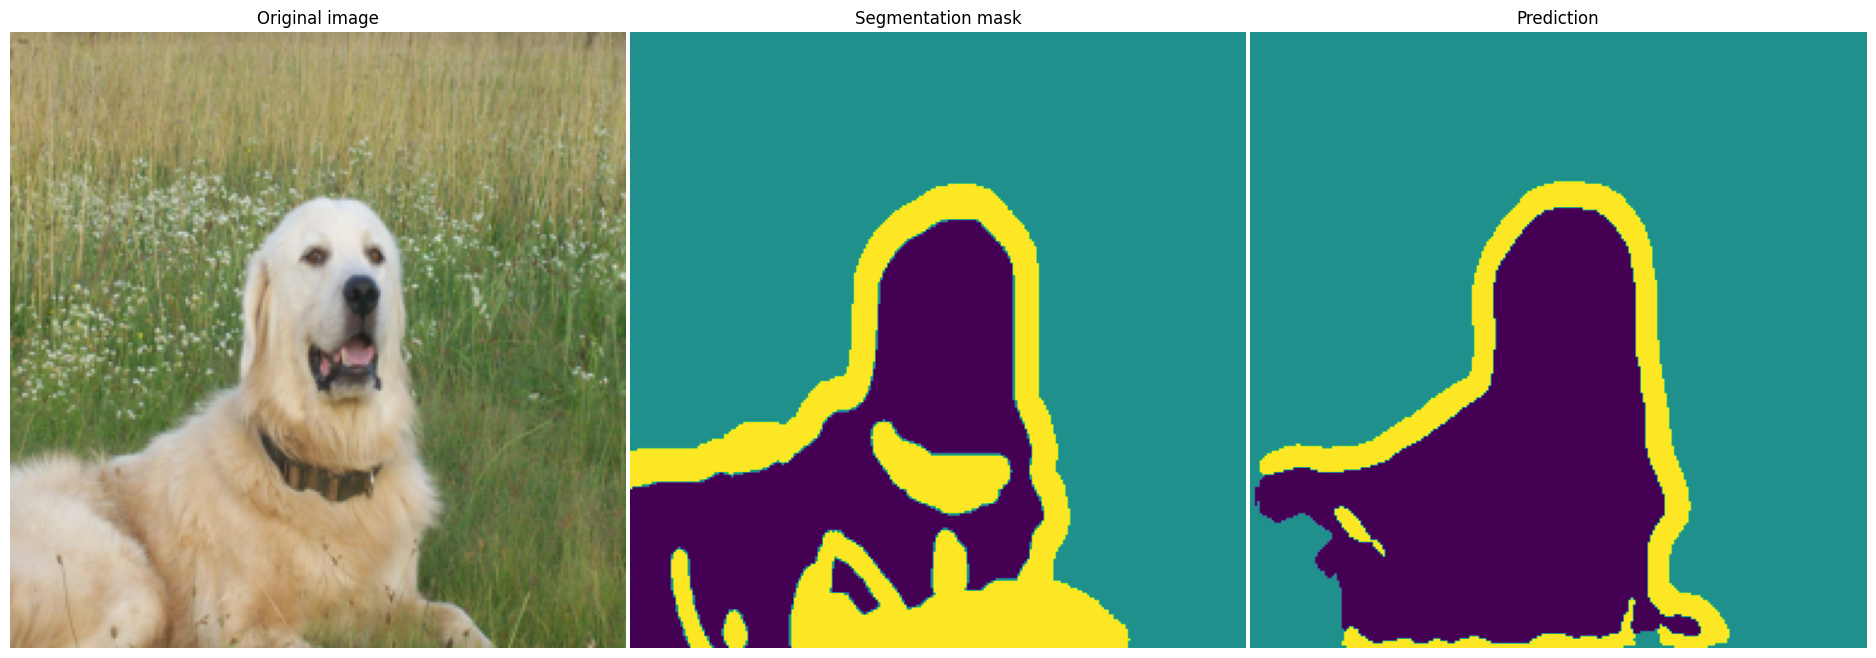

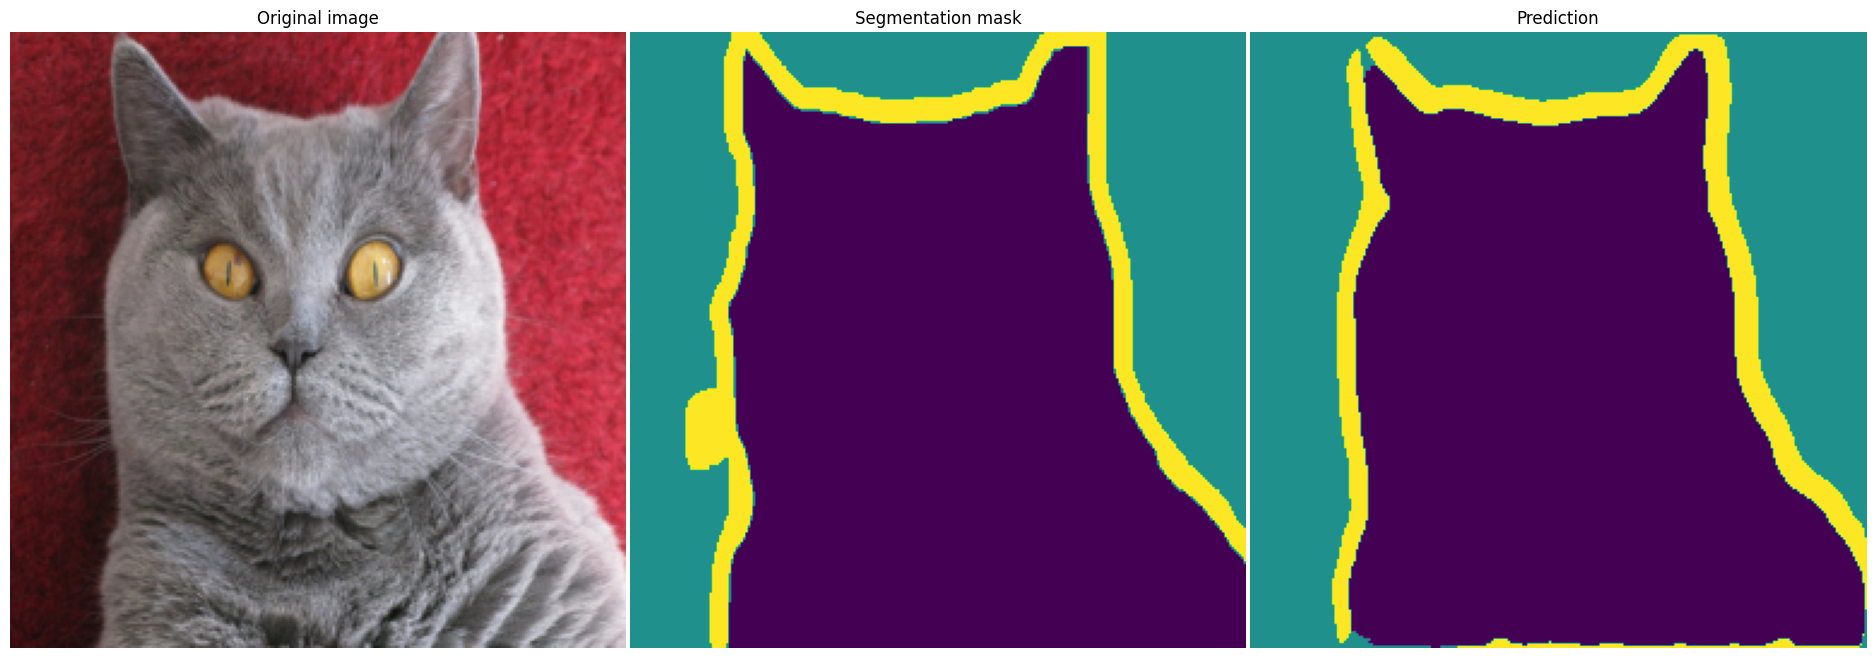

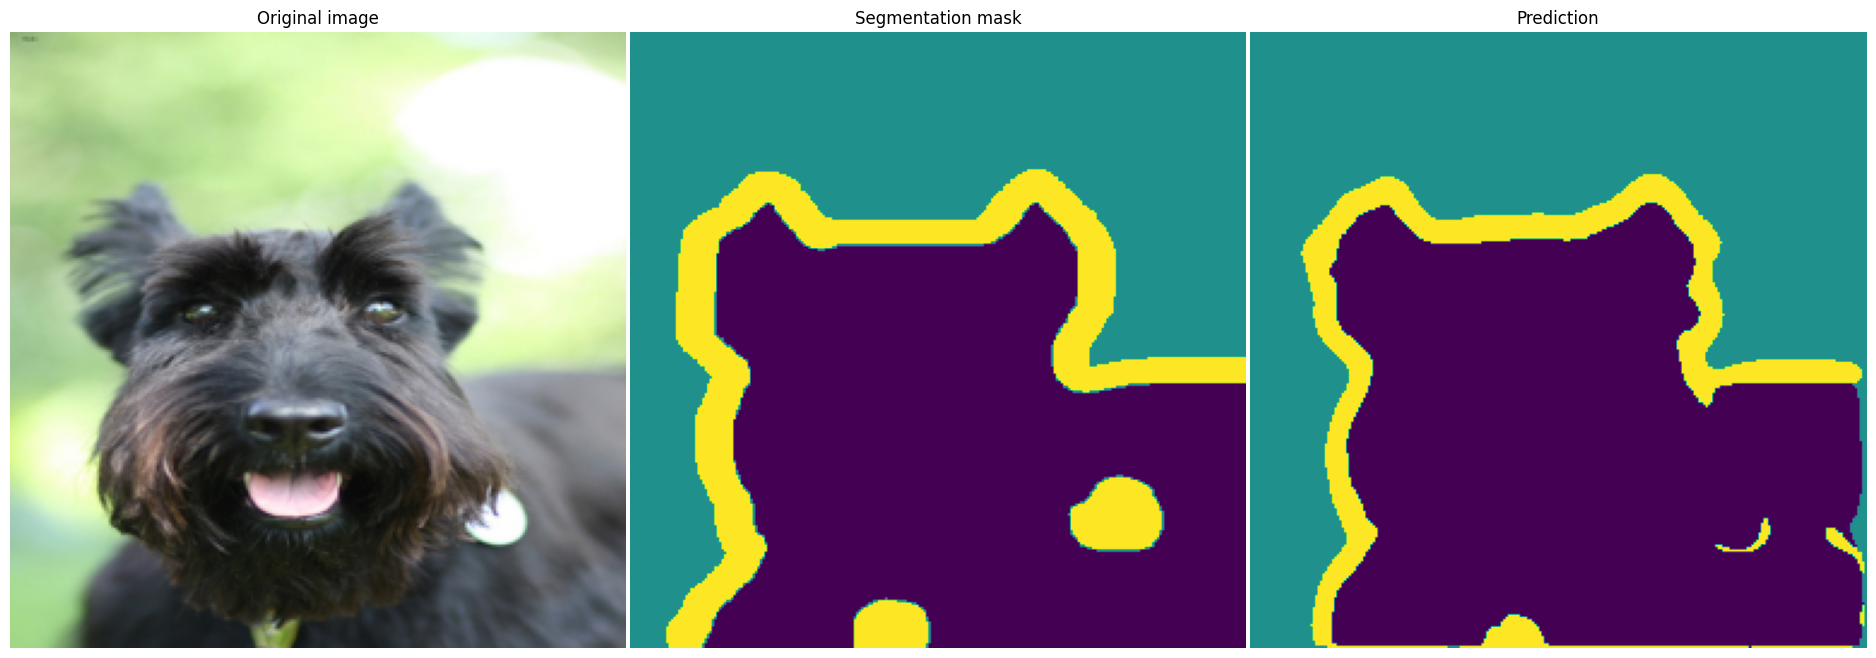

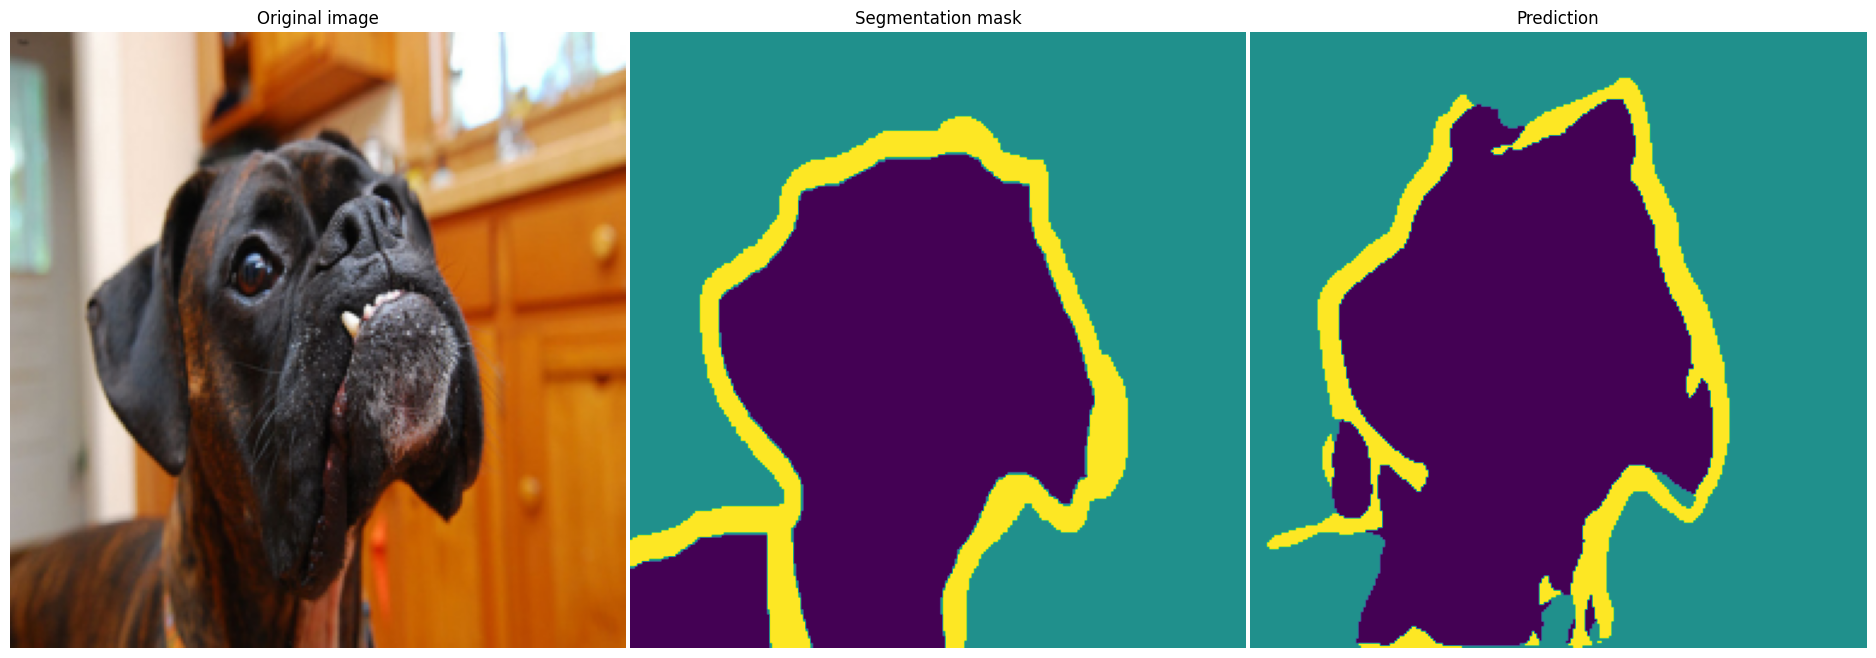

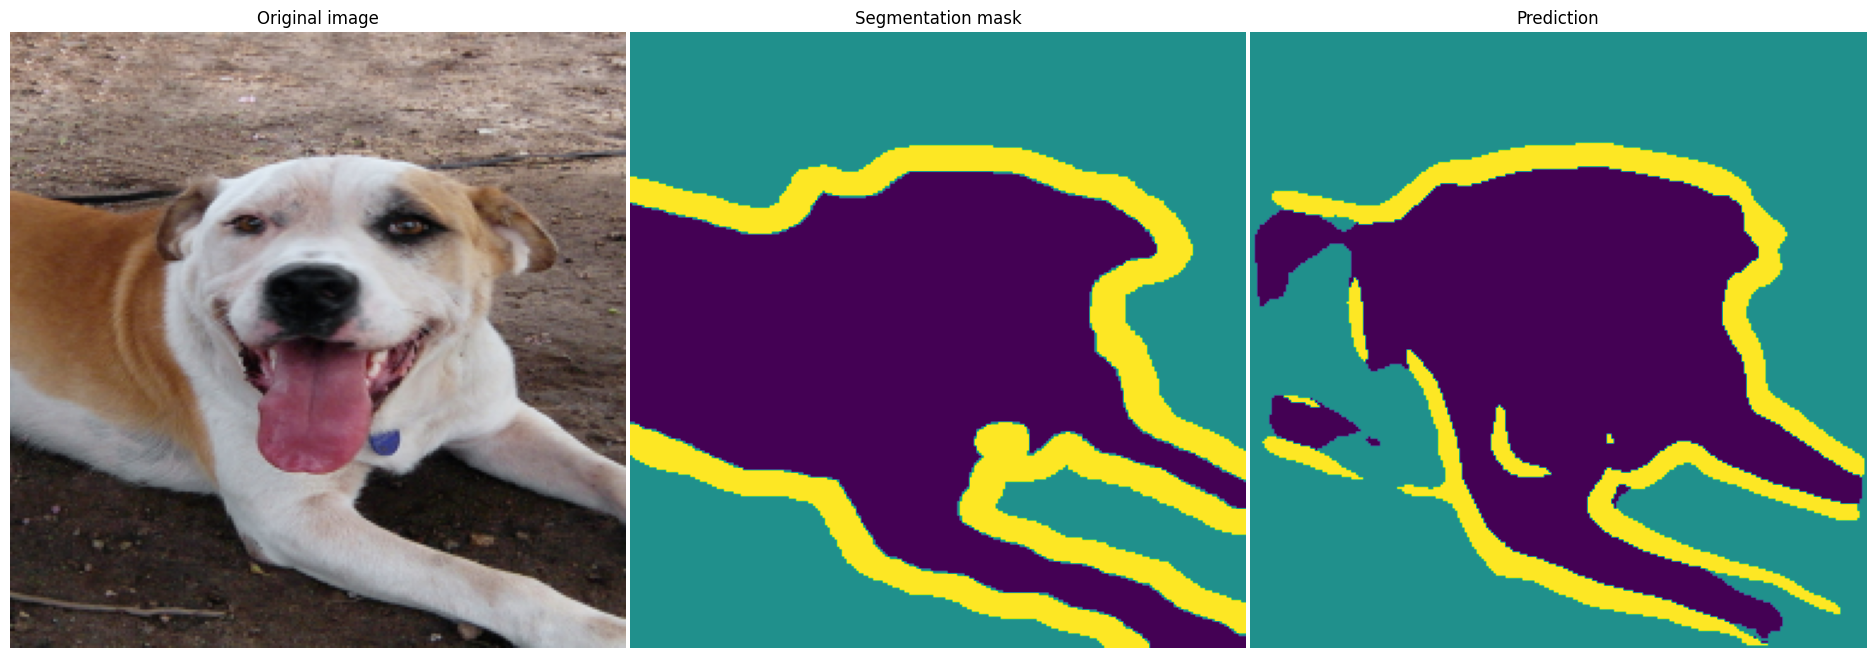

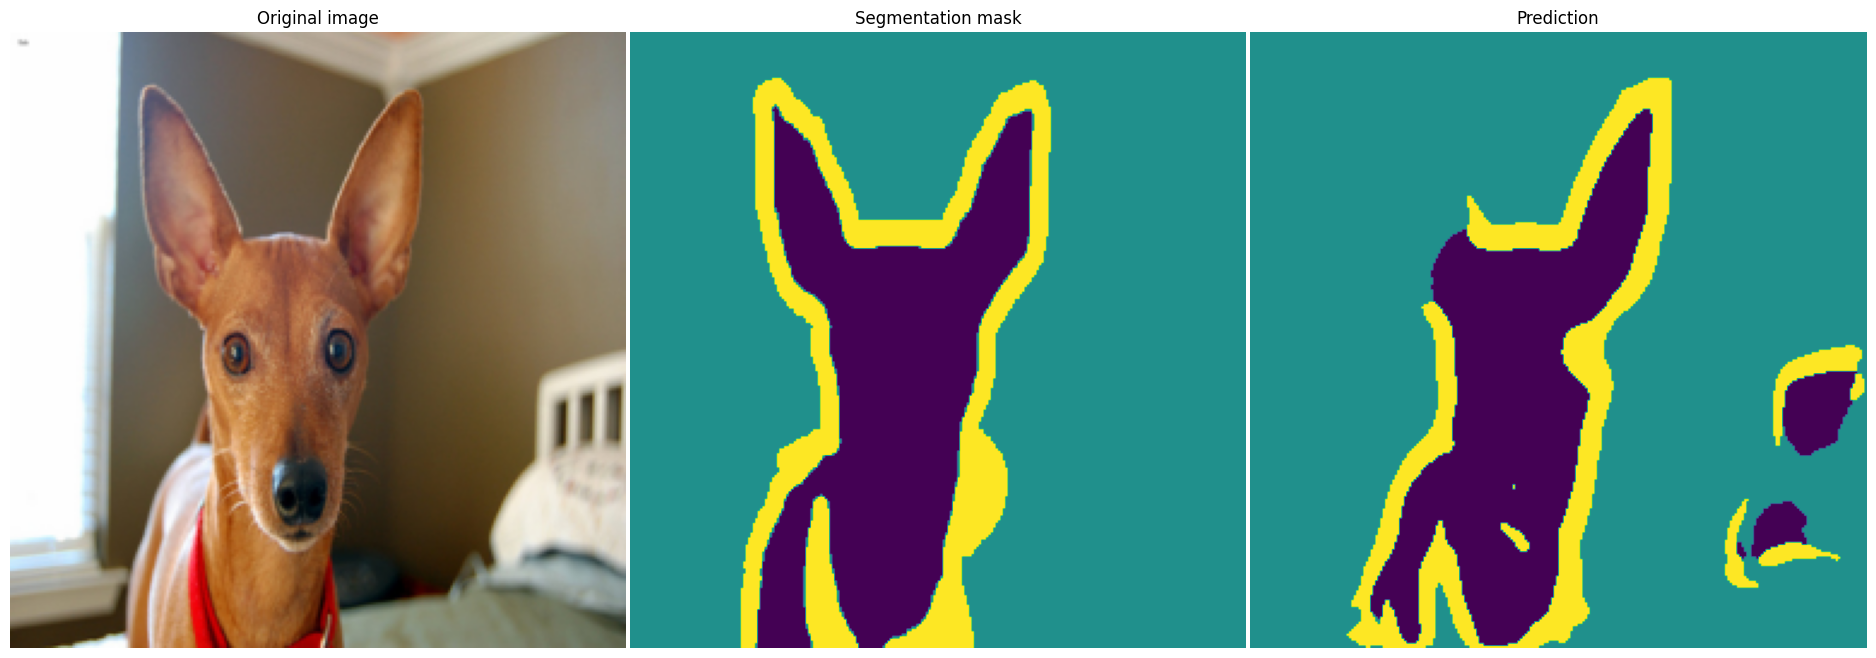

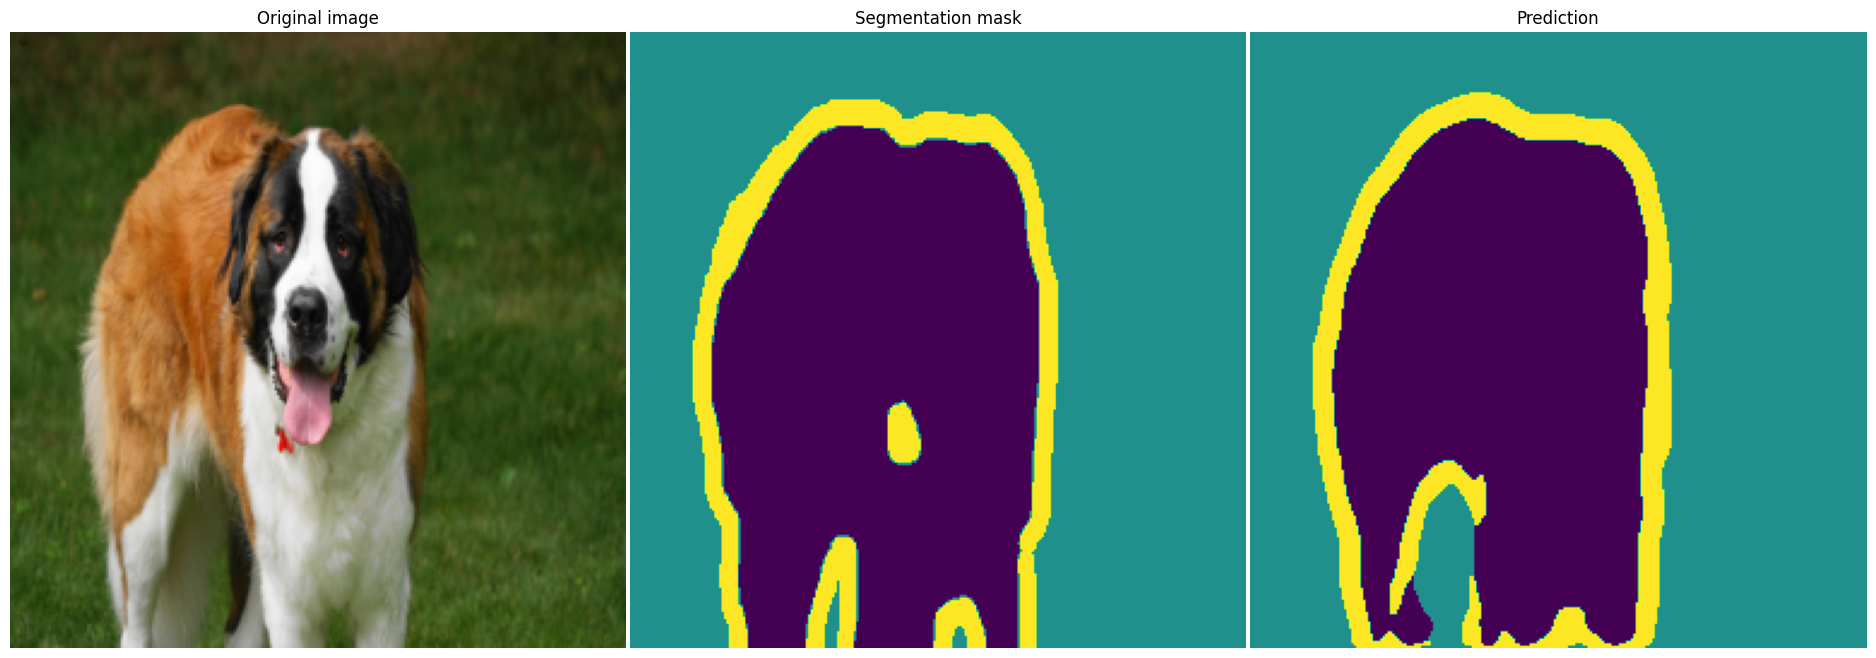

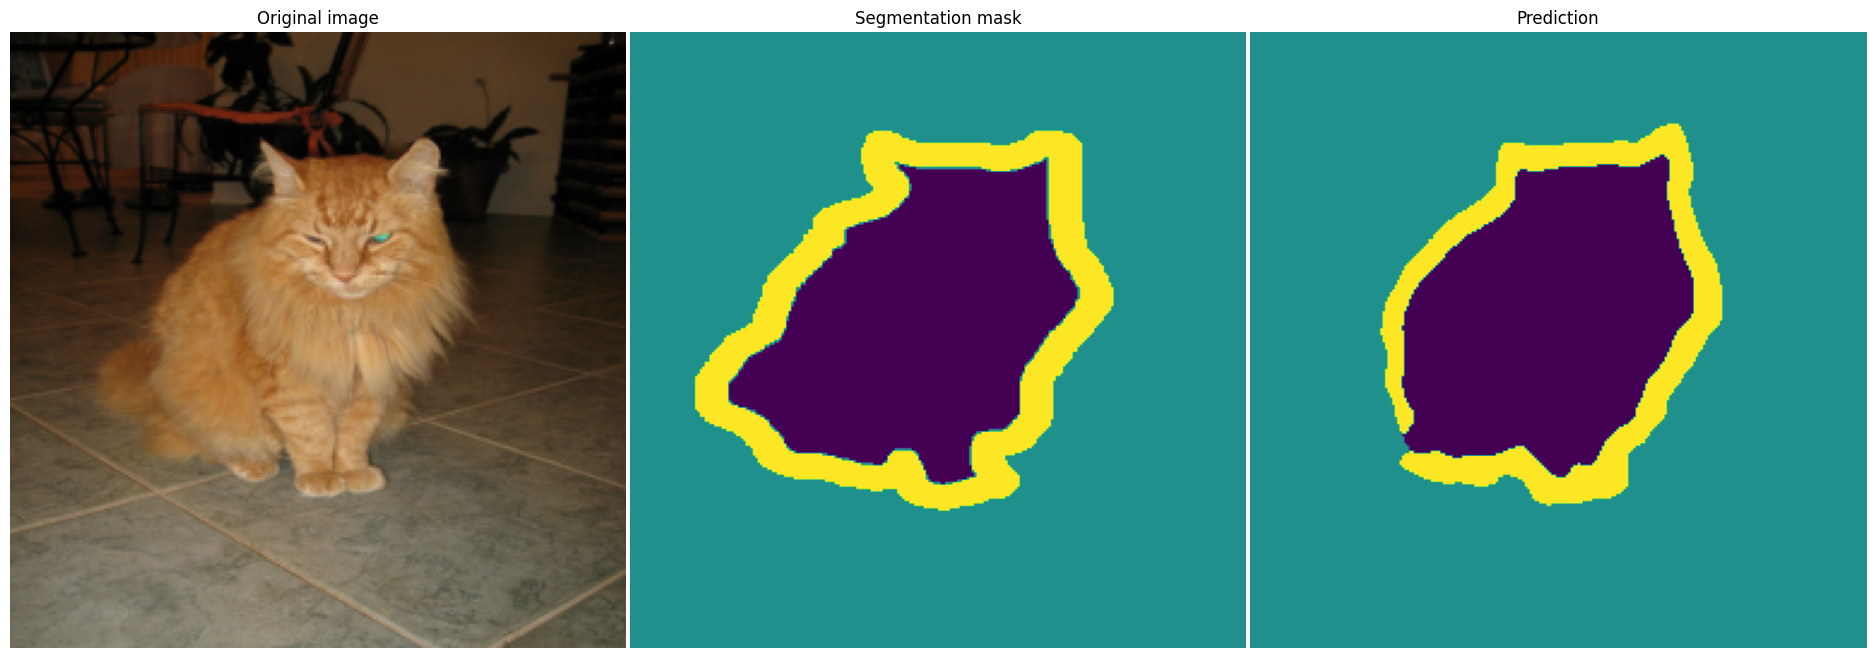

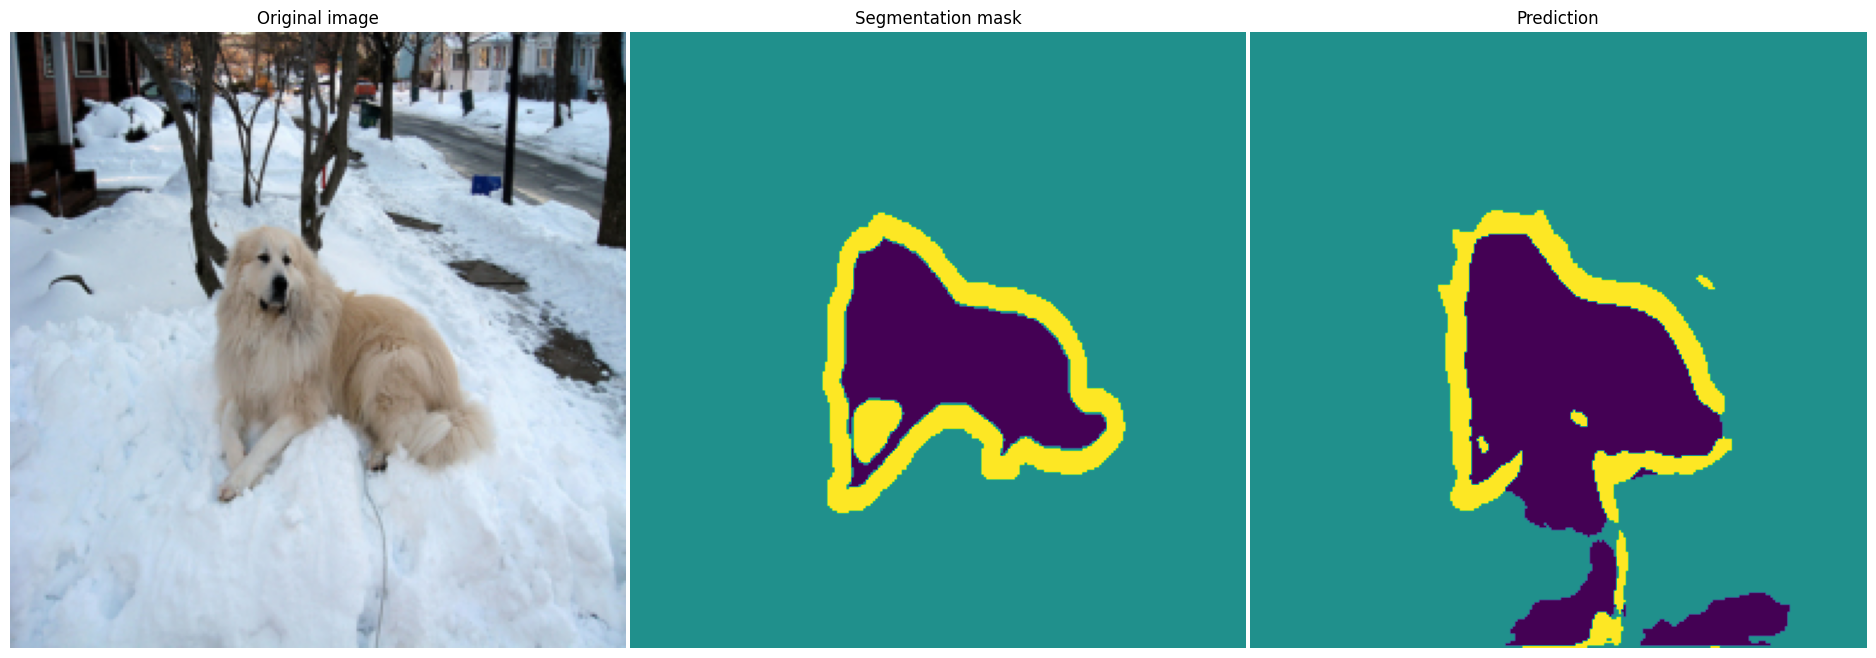

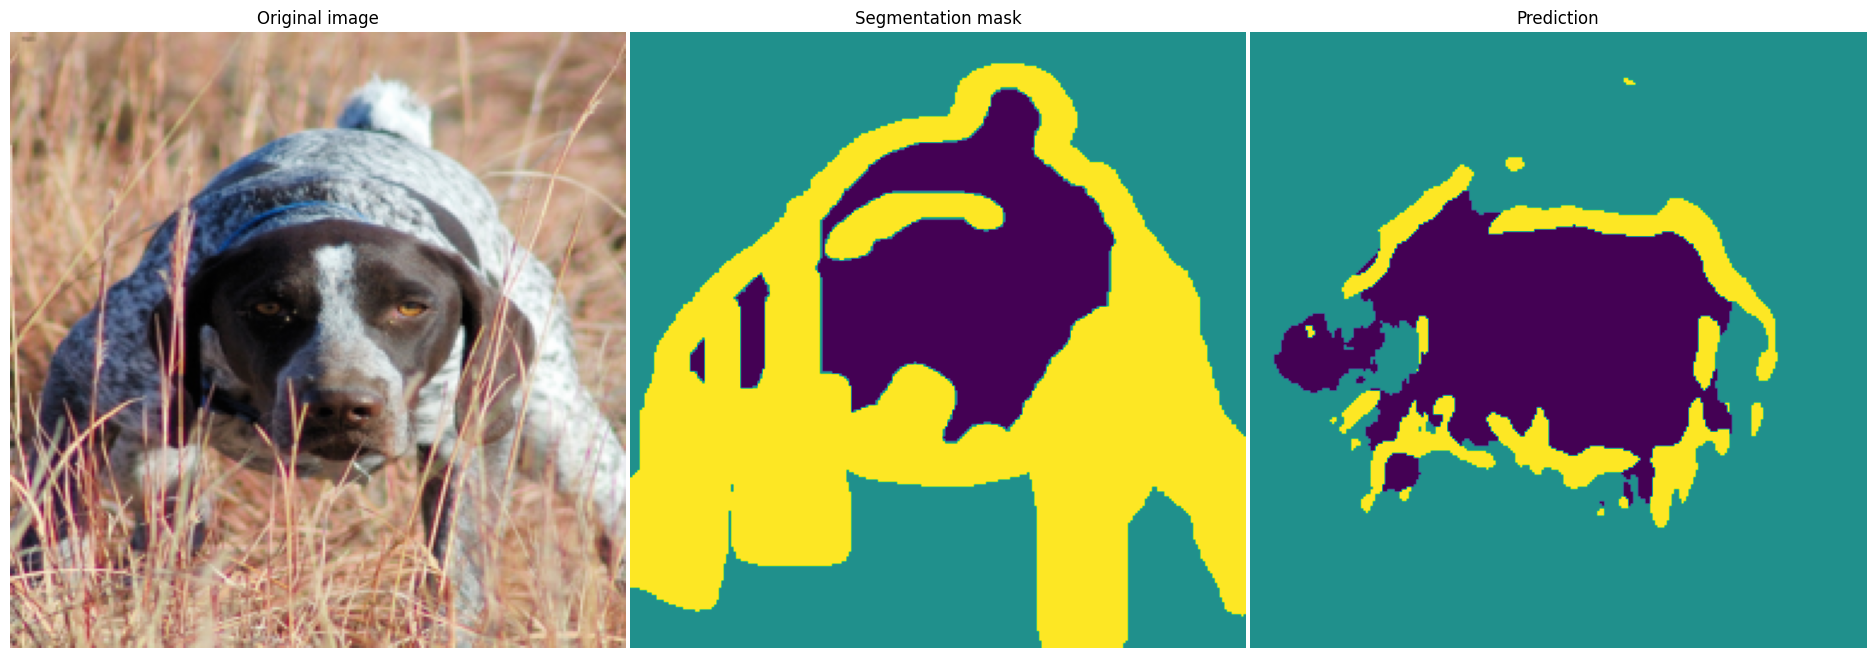

In [11]:
whole_train_valid_cycle(model, 10, 'UNET segmentation')

In [8]:
from torch.utils.data import Subset

np.random.seed(100)
idx = np.random.randint(len(valid_dataset), size=200)

subset_valid_dataset = Subset(valid_dataset, idx)

valid_loader_check = DataLoader(subset_valid_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

@torch.inference_mode()
def save_predictions(model, loader):
    model.eval()
    predictions = []

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.squeeze(1).to(device)

        output = model(x)

        _, y_pred = output.max(dim=1)
        
        predictions.append(y_pred.cpu())  # Перемещаем предсказания на CPU и добавляем в список

    # Объединяем предсказания в единый тензор
    predictions_tensor = torch.cat(predictions, dim=0)  # Объединяем вдоль batch-дименсии
    predictions_tensor = predictions_tensor.unsqueeze(1)  # Добавляем размерность канала
    predictions_tensor = predictions_tensor.to(torch.uint8)  # Преобразуем в uint8

    # Проверяем форму тензора
    assert predictions_tensor.shape == (200, 1, 256, 256), \
        f"Форма тензора {predictions_tensor.shape}, ожидается (200, 1, 256, 256)"

    torch.save(predictions_tensor.to(torch.uint8), '/kaggle/working/predictions.pt')
    

In [9]:
save_predictions(model, valid_loader_check)

Evaluation: 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]
